# RAVIR Challenge pipeline

In [1]:
# External modules
%matplotlib inline
import sys
import tensorflow as tf
import warnings
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

# Local modules
sys.path.append("/tf/ravir-challenge/") # Root path, change accordingly
from utils import *
from model import *

In [2]:
# Combination of tweaks which aims to prevent death of kernel
tf.compat.v1.disable_eager_execution()
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

# Surpresses warning messages which can be safely ignored
warnings.simplefilter(action = 'ignore', category = UserWarning)

In [3]:
# Data parameters
train_dir = '/tf/ravir-challenge/dataset/train'
test_dir = '/tf/ravir-challenge/dataset/test'
img_w, img_h, img_c = 768, 768, 1
val_ratio = 0.2

# Model parameters
base = 8
batch_normalization = True
dropout_layers = True
dropout_rate = 0.3
optimizer = Adam
n_classes = 3
learning_rate = 1e-4
loss_func = weighted_loss
weight_strength = 10
metric = [dice_coef]
batch_size = 1
epochs = 30

# If image debugging information should be displayed
debugging = True

In [4]:
# Read data
image_list = get_file_list(train_dir, 'training_images')
mask_list = get_file_list(train_dir, 'training_masks')


Shape and Unique values of image :
 (768, 768, 1) 
 [0.         0.00392157 0.00784314 0.03137255 0.03921569 0.04313726
 0.0627451  0.07058824 0.07450981 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 0.3372549  0.34117648 0.34509805 0.34901962
 0.3529412  0.35686275 0.36078432 0.3647059  0.36862746 0.37254903
 0.3764706  

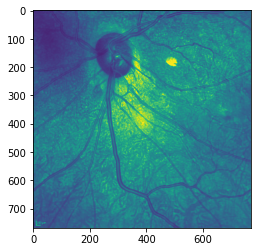


Shape and Unique values of mask :
 (768, 768, 1) 
 [0. 1. 2.]


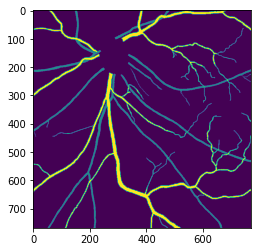


Shape and Unique values of weight map :
 (768, 768, 1) 
 [0.         0.49803922 0.5019608  1.        ]


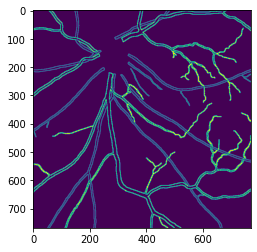

In [5]:
# Load train data and extract weight maps from masks
train_image_list, train_mask_list, val_image_list, val_mask_list \
= get_train_val_lists(image_list, mask_list, val_ratio)

x_train = load_image(train_image_list, img_w, img_h, img_c, 'image')
y_train = load_image(train_mask_list, img_w, img_h, img_c, 'mask')
w_train = extract_weight_maps(train_mask_list, img_w, img_h)

x_val = load_image(val_image_list, img_w, img_h, img_c, 'image')
y_val = load_image(val_mask_list, img_w, img_h, img_c, 'mask')
w_val = extract_weight_maps(val_mask_list, img_w, img_h)

if debugging:
    get_image_information(x_train, img_w, img_h, 'image', loaded = True)
    get_image_information(y_train, img_w, img_h, 'mask', loaded = True)
    get_image_information(w_train, img_w, img_h, 'weight map', loaded = True)

In [6]:
# Compile model
weight_map = Input(shape=(img_w, img_h, img_c), name='weight_map')
inputs_layer = Input(shape=(img_w, img_h, img_c), name='input_layer')
weighted_input = (inputs_layer, weight_map)

model = get_weighted_unet(weighted_input, 
                          base,
                          batch_normalization, 
                          dropout_layers, dropout_rate,
                          img_w, img_h, img_c,
                          n_classes)

model.compile(optimizer = optimizer(learning_rate),
              loss = loss_func(weight_map, weight_strength),
              metrics = metric)

Instructions for updating:
Colocations handled automatically by placer.
Model: "Weighted UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 768, 768, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 768, 768, 8)  80          ['input_layer[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 768, 768, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
              

 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 96, 96, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 48, 48, 64)  0           ['activation_7[0][0]']           
                                                                                                  
 dropout_3 (Dropout)            (None, 48, 48, 64)   0           ['max_pooling2d_3[0][0]']        
                                                                                                  
 conv2d_8 (Conv2D)              (None, 48, 48, 128)  73856       ['dropout_3[0][0]']              
                                                                                                  
 batch_nor

 batch_normalization_14 (BatchN  (None, 384, 384, 16  64         ['conv2d_14[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_14 (Activation)     (None, 384, 384, 16  0           ['batch_normalization_14[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 384, 384, 16  2320        ['activation_14[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 384, 384, 16  64         ['conv2d_15[0][0]']              
 ormalizat

In [7]:
# Fit model
train_generator = generator(x_train, y_train, w_train, batch_size)

model_history = model.fit(train_generator,
                          steps_per_epoch = x_train.shape[0]//batch_size,
                          epochs = epochs,
                          validation_steps = len(x_val),
                          validation_data = ([x_val, w_val], y_val),
                          shuffle = False,
                          class_weight = 'auto')

Epoch 1/30
19/19 [==============================] - 7s 105ms/step - batch: 9.0000 - size: 1.0000 - loss: 0.0691 - dice_coef: 0.4682 - val_loss: 0.0065 - val_dice_coef: 0.1397
Epoch 2/30
19/19 [==============================] - 2s 80ms/step - batch: 9.0000 - size: 1.0000 - loss: 0.0643 - dice_coef: 0.4645 - val_loss: 0.0067 - val_dice_coef: 0.1397
Epoch 3/30
19/19 [==============================] - 2s 81ms/step - batch: 9.0000 - size: 1.0000 - loss: 0.0588 - dice_coef: 0.4665 - val_loss: 0.0069 - val_dice_coef: 0.1397
Epoch 4/30
19/19 [==============================] - 2s 79ms/step - batch: 9.0000 - size: 1.0000 - loss: 0.0550 - dice_coef: 0.4709 - val_loss: 0.0071 - val_dice_coef: 0.1397
Epoch 5/30
19/19 [==============================] - 1s 79ms/step - batch: 9.0000 - size: 1.0000 - loss: 0.0504 - dice_coef: 0.4669 - val_loss: 0.0074 - val_dice_coef: 0.1397
Epoch 6/30
19/19 [==============================] - 2s 83ms/step - batch: 9.0000 - size: 1.0000 - loss: 0.0475 - dice_coef: 0.468

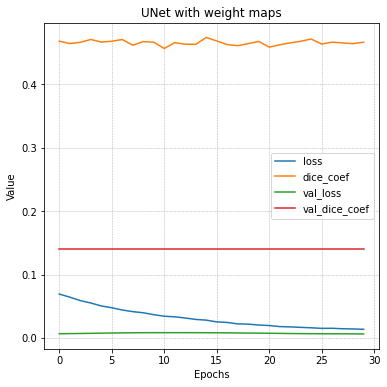

In [8]:
# Plot parameters
size_x = 6
size_y = 6
title = 'UNet with weight maps'
x_label = 'Epochs'
y_label = 'Value'
legend = True
print_keys = False

# Plot model history to evaluate performance
plot_model_history(size_x, size_y, title, x_label, y_label, legend, print_keys, model_history)

In [9]:
# Read and load test images for prediction
test_image_list = get_file_list(test_dir, '')
x_test = load_image(test_image_list, img_w, img_h, img_c, 'image')
w_test = np.ones([x_test.shape[0], img_w, img_h, img_c]) # Weight map filled with ones for prediction purposes


Shape and Unique values of prediction :
 (768, 768, 3) 
 [6.9612540e-08 1.1889554e-07 1.9445882e-07 ... 9.9999845e-01 9.9999881e-01
 9.9999893e-01]


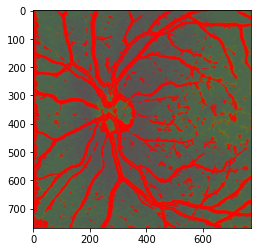

In [10]:
# Predict test images
predicted_mask_list = model.predict([x_test, w_test])
predicted_mask_list= predicted_mask_list

if debugging:
    get_image_information(predicted_mask_list, img_w, img_h, 'prediction', loaded = True)

1  out of  19  converted
2  out of  19  converted
3  out of  19  converted
4  out of  19  converted
5  out of  19  converted
6  out of  19  converted
7  out of  19  converted
8  out of  19  converted
9  out of  19  converted
10  out of  19  converted
11  out of  19  converted
12  out of  19  converted
13  out of  19  converted
14  out of  19  converted
15  out of  19  converted
16  out of  19  converted
17  out of  19  converted
18  out of  19  converted
19  out of  19  converted

Shape and Unique values of prediction mask :
 (768, 768) 
 [ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 

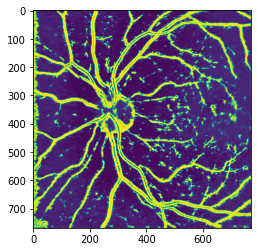

In [11]:
# Save predicted images to folder
save_predictions(predicted_mask_list[0:20])

if debugging:
    prediction_list = get_file_list('/tf/ravir-challenge/predictions', '')
    get_image_information(prediction_list, img_w, img_h, 'prediction mask', loaded = False)